In [25]:
import gym
import numpy as np
import tensorflow.compat.v1 as tf
import collections

# optimized for Tf2
tf.disable_v2_behavior()
print("tf_ver:{}".format(tf.__version__))

env = gym.make('CartPole-v1')
np.random.seed(1)


class PolicyNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='policy_network'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        with tf.variable_scope(name):

            self.state = tf.placeholder(tf.float32, [None, self.state_size], name="state")
            self.action = tf.placeholder(tf.int32, [self.action_size], name="action")
            self.R_t = tf.placeholder(tf.float32, name="total_rewards")

            tf2_initializer = tf.keras.initializers.glorot_normal(seed=0)
            self.W1 = tf.get_variable("W1", [self.state_size, 12], initializer=tf2_initializer)
            self.b1 = tf.get_variable("b1", [12], initializer=tf2_initializer)
            self.W2 = tf.get_variable("W2", [12, self.action_size], initializer=tf2_initializer)
            self.b2 = tf.get_variable("b2", [self.action_size], initializer=tf2_initializer)

            self.Z1 = tf.add(tf.matmul(self.state, self.W1), self.b1)
            self.A1 = tf.nn.relu(self.Z1)
            self.output = tf.add(tf.matmul(self.A1, self.W2), self.b2)

            # Softmax probability distribution over actions
            self.actions_distribution = tf.squeeze(tf.nn.softmax(self.output))
            # Loss with negative log probability
            self.neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.output, labels=self.action)
            self.loss = tf.reduce_mean(self.neg_log_prob * self.R_t)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)


def run():
    # Define hyperparameters
    state_size = 4
    action_size = env.action_space.n

    max_episodes = 5000
    max_steps = 501
    discount_factor = 0.99
    learning_rate = 0.0004

    render = False

    # Initialize the policy network
    tf.reset_default_graph()
    policy = PolicyNetwork(state_size, action_size, learning_rate)
    a = []
    b = []
    c = []

    # Start training the agent with REINFORCE algorithm
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        solved = False
        Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
        episode_rewards = np.zeros(max_episodes)
        average_rewards = 0.0

        for episode in range(max_episodes):
            state = env.reset()
            # print(state)
            state = state.reshape([1, state_size])
            episode_transitions = []

            for step in range(max_steps):
                actions_distribution = sess.run(policy.actions_distribution, {policy.state: state})
                action = np.random.choice(np.arange(len(actions_distribution)), p=actions_distribution)
                next_state, reward, done, _ = env.step(action)
                next_state = next_state.reshape([1, state_size])

                if render:
                    env.render()

                action_one_hot = np.zeros(action_size)
                action_one_hot[action] = 1
                episode_transitions.append(Transition(state=state, action=action_one_hot, reward=reward, next_state=next_state, done=done))
                episode_rewards[episode] += reward

                if done:
                    a.append(episode_rewards[episode])
                    if episode > 98:
                        # Check if solved
                        average_rewards = np.mean(episode_rewards[(episode - 99):episode+1])
                        b.append(average_rewards)
                    print("Episode {} Reward: {} Average over 100 episodes: {}".format(episode, episode_rewards[episode], round(average_rewards, 2)))
                    if average_rewards > 475:
                        print(' Solved at episode: ' + str(episode))
                        solved = True
                    break
                state = next_state

            if solved:
                break

            # Compute Rt for each time-step t and update the network's weights
            for t, transition in enumerate(episode_transitions):
                total_discounted_return = sum(discount_factor ** i * t.reward for i, t in enumerate(episode_transitions[t:])) # Rt
                feed_dict = {policy.state: transition.state, policy.R_t: total_discounted_return, policy.action: transition.action}
                _, loss = sess.run([policy.optimizer, policy.loss], feed_dict)
            c.append(loss)
    return a, b, c


if __name__ == '__main__':
    a, b, c = run()


tf_ver:2.15.0


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0 Reward: 22.0 Average over 100 episodes: 0.0
Episode 1 Reward: 18.0 Average over 100 episodes: 0.0
Episode 2 Reward: 23.0 Average over 100 episodes: 0.0
Episode 3 Reward: 10.0 Average over 100 episodes: 0.0
Episode 4 Reward: 10.0 Average over 100 episodes: 0.0
Episode 5 Reward: 12.0 Average over 100 episodes: 0.0
Episode 6 Reward: 15.0 Average over 100 episodes: 0.0
Episode 7 Reward: 42.0 Average over 100 episodes: 0.0
Episode 8 Reward: 19.0 Average over 100 episodes: 0.0
Episode 9 Reward: 11.0 Average over 100 episodes: 0.0
Episode 10 Reward: 21.0 Average over 100 episodes: 0.0
Episode 11 Reward: 10.0 Average over 100 episodes: 0.0
Episode 12 Reward: 15.0 Average over 100 episodes: 0.0
Episode 13 Reward: 9.0 Average over 100 episodes: 0.0
Episode 14 Reward: 13.0 Average over 100 episodes: 0.0
Episode 15 Reward: 12.0 Average over 100 episodes: 0.0
Episode 16 Reward: 12.0 Average over 100 episodes: 0.0
Episode 17 Reward: 13.0 Average over 100 episodes: 0.0
Episode 18 Reward: 9.

In [9]:
import gym
import numpy as np
import tensorflow.compat.v1 as tf
import collections
import os
from datetime import datetime
import time
import pdb

# optimized for Tf2
tf.disable_v2_behavior()

algorithm_name = "actor_critic"


# Actor
class PolicyNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='policy_network'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        with tf.variable_scope(name):
            self.state = tf.placeholder(tf.float32, [None, self.state_size], name="state")
            self.advantage_delta = tf.placeholder(tf.float32, name="advantage_delta")
            self.I_factor = tf.placeholder(tf.float32, name="I_factor")

            tf2_initializer = tf.keras.initializers.glorot_normal(seed=0)
            self.W1 = tf.get_variable("W1", [self.state_size, 12], initializer=tf2_initializer)
            self.b1 = tf.get_variable("b1", [12], initializer=tf2_initializer)
            self.W2 = tf.get_variable("W2", [12, self.action_size], initializer=tf2_initializer)
            self.b2 = tf.get_variable("b2", [self.action_size], initializer=tf2_initializer)

            self.Z1 = tf.add(tf.matmul(self.state, self.W1), self.b1)
            self.A1 = tf.nn.relu(self.Z1)
            self.output = tf.add(tf.matmul(self.A1, self.W2), self.b2)

            # Softmax probability distribution over actions
            self.actions_distribution = tf.squeeze(tf.nn.softmax(self.output))
            self.actions_log_probs = tf.math.log(self.actions_distribution)

            # Loss calculation  - for gradient ascent we minimize the negative loss. Loss = delta*I*ln(Pi)
            self.loss = self.I_factor * -tf.math.reduce_sum(self.advantage_delta * self.actions_log_probs)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)


# Critic
class ValueNetwork:
    def __init__(self, state_size, learning_rate, name='state_value_network'):
        self.state_size = state_size
        self.learning_rate = learning_rate

        with tf.variable_scope(name):
            # Place holders for future calculation
            self.state = tf.placeholder(tf.float32, [None, self.state_size], name="state")
            self.I_factor = tf.placeholder(tf.float32, name="I_factor")
            self.advantage_delta = tf.placeholder(tf.float32, name="advantage_delta")

            tf2_initializer = tf.keras.initializers.glorot_normal(seed=0)
            self.W1 = tf.get_variable("W1", [self.state_size, 64], initializer=tf2_initializer)
            self.b1 = tf.get_variable("b1", [64], initializer=tf2_initializer)
            self.W2 = tf.get_variable("W2", [64, 16], initializer=tf2_initializer)
            self.b2 = tf.get_variable("b2", [16], initializer=tf2_initializer)
            self.W3 = tf.get_variable("W3", [16, 1], initializer=tf2_initializer)
            self.b3 = tf.get_variable("b3", [1], initializer=tf2_initializer)

            self.Z1 = tf.add(tf.matmul(self.state, self.W1), self.b1)
            self.A1 = tf.nn.relu(self.Z1)
            self.Z2 = tf.add(tf.matmul(self.A1, self.W2), self.b2)
            self.A2 = tf.nn.relu(self.Z2)
            self.output = tf.add(tf.matmul(self.A2, self.W3), self.b3)

            # Loss calculation  - for gradient ascent we minimize the negative loss. Loss = delta*I*V
            self.loss = -self.advantage_delta * self.I_factor * self.output #
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)


def run(discount_factor, policy_learning_rate, sv_learning_rate):
    env = gym.make('CartPole-v1')
    np.random.seed(SEED)
    env.seed(SEED)
    tf.set_random_seed(SEED)
    rewards, mean_rewards, losses = [], [], []
    # Define hyperparameters
    state_size = 4
    action_size = env.action_space.n

    max_episodes = 5000
    max_steps = 501
    discount_factor = discount_factor
    policy_learning_rate = policy_learning_rate
    sv_learning_rate = sv_learning_rate
    render = False

    # Initialize the policy and the state-value network
    tf.reset_default_graph()

    policy = PolicyNetwork(state_size, action_size, policy_learning_rate)
    state_value = ValueNetwork(state_size, sv_learning_rate)

    # Start training the agent with REINFORCE algorithm
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        solved = False
        episode_rewards = np.zeros(max_episodes)
        average_rewards = 0.0
        stable = False
        # pdb.set_trace()
        for episode in range(max_episodes):

            # pdb.set_trace
            state = env.reset()
            state = state.reshape([1, state_size])
            I_factor = 1

            for step in range(max_steps):
                # pdb.set_trace()

                # Take action A ~ pi(*|S,thetha) and observe S',R.
                actions_distribution = sess.run(policy.actions_distribution, {policy.state: state})
                try:
                    action = np.random.choice(np.arange(len(actions_distribution)), p=actions_distribution)
                except:
                    # pdb.set_trace()
                    print("hey")
                next_state, reward, done, _ = env.step(action)
                next_state = next_state.reshape([1, state_size])

                # action_one_hot = np.zeros(action_size)
                # action_one_hot[action] = 1
                episode_rewards[episode] += reward

                if render:
                    env.render()

                # Calculate state-value output for current state
                feed_dict = {state_value.state: state}
                value_current_state = sess.run(state_value.output, feed_dict)

                # Calculate state-value output for next state
                feed_dict = {state_value.state: next_state}
                value_next_state = sess.run(state_value.output, feed_dict)

                # Calculate advantage
                target = reward if done else reward + discount_factor * value_next_state
                advantage_delta = target - value_current_state

                # Update the state_value network weights
                feed_dict = {state_value.state: state, state_value.I_factor: I_factor,
                             state_value.advantage_delta: advantage_delta}
                _, loss_state = sess.run([state_value.optimizer, state_value.loss], feed_dict)

                # Update the policy network weights
                feed_dict = {policy.state: state, policy.I_factor: I_factor,
                             policy.advantage_delta: advantage_delta}
                if stable:
                  # We prevent the network weights from changing after it is stable
                  loss_policy = sess.run(policy.loss, feed_dict)
                else:
                  _, loss_policy = sess.run([policy.optimizer, policy.loss], feed_dict)

                if done:

                    if episode > 98:
                        average_rewards = np.mean(episode_rewards[(episode - 99):episode + 1])
                    lst_5_avg = np.mean(episode_rewards[(episode - 5):episode + 1])
                    if lst_5_avg > 475:
                        stable = True

                    print(
                        "Episode {} Reward: {} Average over 100 episodes: {}".format(episode, episode_rewards[episode],
                                                                                     round(average_rewards, 2)))
                    if average_rewards > 475:
                        print(' Solved at episode: ' + str(episode))
                        solved = True
                    break

                # I <- gamma*I
                I_factor *= discount_factor

                # S<-S'
                state = next_state

            if solved:
                break

            rewards.append(episode_rewards[episode])
            mean_rewards.append(average_rewards)
            losses.append(loss_policy)
    return episode, rewards, mean_rewards, losses


if __name__ == '__main__':
    SEED = 42
    # optimal_sv_lr = 0.0007
    # optimal_policy_lr = 0.0005

    # optimal_sv_lr = tf.keras.optimizers.schedules.ExponentialDecay(
    # initial_learning_rate,
    # decay_steps=100000,
    # decay_rate=0.96,
    # staircase=True)

    optimal_sv_lr = 0.0007
    optimal_policy_lr = 0.01

    optimal_df = 0.99
    algorithm_name = "actor_critic"
    last_episode_a_c, rewards_a_c, mean_rewards_a_c, losses_a_c = run(discount_factor=optimal_df,
                                                      policy_learning_rate=optimal_policy_lr,
                                                      sv_learning_rate=optimal_sv_lr)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


Episode 0 Reward: 16.0 Average over 100 episodes: 0.0
Episode 1 Reward: 12.0 Average over 100 episodes: 0.0
Episode 2 Reward: 52.0 Average over 100 episodes: 0.0
Episode 3 Reward: 23.0 Average over 100 episodes: 0.0
Episode 4 Reward: 64.0 Average over 100 episodes: 0.0
Episode 5 Reward: 17.0 Average over 100 episodes: 0.0
Episode 6 Reward: 16.0 Average over 100 episodes: 0.0
Episode 7 Reward: 66.0 Average over 100 episodes: 0.0
Episode 8 Reward: 13.0 Average over 100 episodes: 0.0
Episode 9 Reward: 34.0 Average over 100 episodes: 0.0
Episode 10 Reward: 19.0 Average over 100 episodes: 0.0
Episode 11 Reward: 13.0 Average over 100 episodes: 0.0
Episode 12 Reward: 13.0 Average over 100 episodes: 0.0
Episode 13 Reward: 31.0 Average over 100 episodes: 0.0
Episode 14 Reward: 15.0 Average over 100 episodes: 0.0
Episode 15 Reward: 29.0 Average over 100 episodes: 0.0
Episode 16 Reward: 26.0 Average over 100 episodes: 0.0
Episode 17 Reward: 23.0 Average over 100 episodes: 0.0
Episode 18 Reward: 1

In [7]:
import gym
import numpy as np
import tensorflow.compat.v1 as tf
import collections
import os
import pdb
from datetime import datetime
import time


# optimized for Tf2
tf.disable_v2_behavior()

class PolicyNetwork:
    def __init__(self, state_size, action_size, name='policy_network'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = tf.placeholder(tf.float32, [], name="learning_rate")

        with tf.variable_scope(name):

            self.state = tf.placeholder(tf.float32, [None, self.state_size], name="state")
            self.gamma_t = tf.placeholder(tf.float32, name="gamma_t")
            self.advantage_delta = tf.placeholder(tf.float32, name="advantage_delta")

            tf2_initializer = tf.keras.initializers.glorot_normal(seed=0)
            self.W1 = tf.get_variable("W1", [self.state_size, 12], initializer=tf2_initializer)
            self.b1 = tf.get_variable("b1", [12], initializer=tf2_initializer)
            self.W2 = tf.get_variable("W2", [12, self.action_size], initializer=tf2_initializer)
            self.b2 = tf.get_variable("b2", [self.action_size], initializer=tf2_initializer)

            self.Z1 = tf.add(tf.matmul(self.state, self.W1), self.b1)
            # self.A1 = tf.nn.relu(tf.layers.batch_normalization(self.Z1))
            self.A1 = tf.nn.relu(self.Z1)
            self.output = tf.add(tf.matmul(self.A1, self.W2), self.b2)

            # Softmax probability distribution over actions
            self.actions_distribution = tf.squeeze(tf.nn.softmax(self.output))
            self.actions_log_probs = tf.math.log(self.actions_distribution)

            # Loss calculation  - for gradient ascent we minimize the negative loss. Loss = delta*I*ln(Pi)
            self.loss = self.gamma_t * -tf.math.reduce_sum(self.advantage_delta * self.actions_log_probs)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)

class ValueNetwork:
    def __init__(self, state_size, name='state_value_network'):
        self.state_size = state_size
        self.learning_rate = tf.placeholder(tf.float32, [], name="learning_rate")


        with tf.variable_scope(name):

            self.state = tf.placeholder(tf.float32, [None, self.state_size], name="state")
            self.advantage_delta = tf.placeholder(tf.float32, name="advantage_delta")
            self.gamma_t = tf.placeholder(tf.float32, name="gamma_t")


            tf2_initializer = tf.keras.initializers.glorot_normal(seed=0)
            self.W1 = tf.get_variable("W1", [self.state_size, 8], initializer=tf2_initializer)
            self.b1 = tf.get_variable("b1", [8], initializer=tf2_initializer)
            self.W2 = tf.get_variable("W2", [8, 1], initializer=tf2_initializer)
            self.b2 = tf.get_variable("b2", [1], initializer=tf2_initializer)

            self.Z1 = tf.add(tf.matmul(self.state, self.W1), self.b1)
            # self.A1 = tf.nn.relu(tf.layers.batch_normalization(self.Z1))
            self.A1 = tf.nn.relu(self.Z1)
            self.output = tf.add(tf.matmul(self.A1, self.W2), self.b2)

            # Loss calculation  - for gradient ascent we minimize the negative loss. Loss = delta*I*V
            self.loss = -self.advantage_delta * self.gamma_t * self.output
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)


def run(discount_factor, policy_learning_rate ,sv_learning_rate):
    env = gym.make('CartPole-v1')
    np.random.seed(SEED)
    env.seed(SEED)
    tf.set_random_seed(SEED)
    rewards, mean_rewards, losses = [], [], []
    # Define hyperparameters
    state_size = 4
    action_size = env.action_space.n

    max_episodes = 5000
    max_steps = 501
    discount_factor = discount_factor
    policy_learning_rate = policy_learning_rate
    sv_learning_rate = sv_learning_rate
    render = False

    # Initialize the policy and the state-value network
    tf.reset_default_graph()
    policy = PolicyNetwork(state_size, action_size)
    state_value = ValueNetwork(state_size)

    # Start training the agent with REINFORCE algorithm
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        solved = False
        Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
        episode_rewards = np.zeros(max_episodes)
        average_rewards = 0.0
        early_stopping = False
        early_stopping_lvl2 = False
        visited = False
        visited_2 = False
        max_r = 0
        max_p = 0
        for episode in range(max_episodes):
            state = env.reset()
            state = state.reshape([1, state_size])
            episode_transitions = []
            since = time.time()
            for step in range(max_steps):
                actions_distribution = sess.run(policy.actions_distribution, {policy.state: state})
                action = np.random.choice(np.arange(len(actions_distribution)), p=actions_distribution)
                next_state, reward, done, _ = env.step(action)
                next_state = next_state.reshape([1, state_size])

                if render:
                    env.render()

                episode_transitions.append(Transition(state=state, action=action, reward=reward, next_state=next_state, done=done))
                episode_rewards[episode] += reward

                if done:
                    if episode > 98:
                        # Check if solved
                        average_rewards = np.mean(episode_rewards[(episode - 99):episode+1])

                    # if np.mean(episode_rewards[(episode - 12):episode + 1]) > 460:
                    #   if policy_learning_rate > 0.0000002:
                    #     print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
                    #     policy_learning_rate = 0.0000002
                    #     sv_learning_rate = 0.0000002
                    # elif np.mean(episode_rewards[(episode - 12):episode + 1]) > 450:
                    #   if policy_learning_rate > 0.0000003:
                    #     print("########################################")
                    #     policy_learning_rate = 0.0000003
                    #     sv_learning_rate = 0.0000003
                    # elif np.mean(episode_rewards[(episode - 8):episode + 1]) > 455:
                    #   if policy_learning_rate > 0.0000005:
                    #     print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
                    #     policy_learning_rate = 0.0000005
                    #     sv_learning_rate = 0.0000007
                    # elif np.mean(episode_rewards[(episode - 6):episode + 1]) > 450:
                    #   if policy_learning_rate > 0.000005:
                    #     print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                    #     policy_learning_rate = 0.000005
                    #     sv_learning_rate = 0.000007
                    # elif np.mean(episode_rewards[(episode - 3):episode + 1]) > 450:
                    #   if policy_learning_rate > 0.00005:
                    #     print("+++++++++++++++++++++++++++++++++")
                    #     policy_learning_rate = 0.00005
                    #     sv_learning_rate = 0.00007
                    if np.mean(episode_rewards[(episode - 3):episode + 1]) > 450:
                      # if policy_learning_rate > 0.00005:
                      print("+++++++++++++++++++++++++++++++++")
                      policy_learning_rate *= 0.6
                      policy_learning_rate = max(policy_learning_rate, 7e-10)
                      sv_learning_rate *= 0.6
                      sv_learning_rate = max(sv_learning_rate, 7e-10)

                    if average_rewards > max_r:
                      max_r = average_rewards
                      max_p = episode
                    print("Episode {} Reward: {} Average over 100 episodes: {} max: {} episode: {}".format(episode, episode_rewards[episode], average_rewards, round(max_r, 2), max_p))
                    if visited_2:
                      print("final state")
                    elif visited:
                      print("semi final state")
                    if average_rewards > 475:
                        print(' Solved at episode: ' + str(episode))
                        time_elapsed = time.time() - since
                        print("Algorithm {} converged after {} seconds".format(algorithm_name, time_elapsed))
                        solved = True
                    break
                state = next_state

            if solved:
                break

            # Compute Gt for each time-step t and update the network's weights
            for t, transition in enumerate(episode_transitions):
                # Compute Gt
                total_discounted_return = sum(discount_factor ** i * t.reward for i, t in enumerate(episode_transitions[t:]))

                # Compute V(S,w)
                feed_dict = {state_value.state: transition.state}
                V_s = sess.run(state_value.output, feed_dict)

                # Compute delta = Gt - V(S,w)
                advantage_delta = total_discounted_return - V_s

                # # Update the state_value network weights
                # feed_dict = {state_value.state: transition.state, state_value.gamma_t: discount_factor**t,
                #              state_value.advantage_delta: advantage_delta}
                # _, loss_state = sess.run([state_value.optimizer, state_value.loss], feed_dict)

                #  _, loss_state = sess.run([state_value.optimizer, state_value.loss],
                #                      feed_dict={state_value.state: transition.state,
                #                                 state_value.gamma_t: discount_factor**t,
                #                                 state_value.advantage_delta: advantage_delta,
                #                                 state_value.learning_rate: sv_learning_rate})


                if np.mean(episode_rewards[(episode - 9):episode + 1]) == 500 or visited_2:
                  # print("final state")
                  # visited_2 = True
                  loss_state = sess.run(state_value.loss,
                                      feed_dict={state_value.state: transition.state,
                                                  state_value.gamma_t: discount_factor**t,
                                                  state_value.advantage_delta: advantage_delta,
                                                  state_value.learning_rate: sv_learning_rate})
                else:
                  _, loss_state = sess.run([state_value.optimizer, state_value.loss],
                                      feed_dict={state_value.state: transition.state,
                                                  state_value.gamma_t: discount_factor**t,
                                                  state_value.advantage_delta: advantage_delta,
                                                  state_value.learning_rate: sv_learning_rate})

                # Update the policy network weights
                feed_dict = {policy.state: transition.state, policy.gamma_t: discount_factor**t,
                             policy.advantage_delta: advantage_delta}

                # if early_stopping_lvl2:
                #   policy_learning_rate *= 0.6
                #   sv_learning_rate *= 0.6

                #   early_stopping_lvl2 = False
                #   print("lvl2")
                #   print(policy_learning_rate, sv_learning_rate)

                # elif early_stopping:
                # # Early stopping to prevent the network weights from changing after it is stable
                #   # loss_policy = sess.run(policy.loss, feed_dict)
                #   if policy_learning_rate >  0.00005:
                #     policy_learning_rate = 0.00005
                #     sv_learning_rate = 0.00007
                #   # print("new lr:",policy_learning_rate )

                if np.mean(episode_rewards[(episode - 4):episode + 1]) == 500 or visited:
                  # print("semi final state")
                  # visited = True
                  # print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
                  loss_policy = sess.run(policy.loss,
                                        feed_dict={policy.state: transition.state,
                                                  policy.gamma_t: discount_factor**t,
                                                  policy.advantage_delta: advantage_delta,
                                                  policy.learning_rate: policy_learning_rate})
                else:
                  _, loss_policy = sess.run([policy.optimizer, policy.loss],
                                      feed_dict={policy.state: transition.state,
                                                  policy.gamma_t: discount_factor**t,
                                                  policy.advantage_delta: advantage_delta,
                                                  policy.learning_rate: policy_learning_rate})


                # if early_stopping:
                #   # early_stopping = False
                #   _, loss_policy = sess.run([policy.optimizer, policy.loss],
                #                       feed_dict={policy.state: transition.state,
                #                                  policy.gamma_t: discount_factor**t,
                #                                  policy.advantage_delta: advantage_delta,
                #                                  policy.learning_rate: policy_learning_rate})

                # else:
                #   # _, loss_policy = sess.run([policy.optimizer, policy.loss], feed_dict)
                #    _, loss_policy = sess.run([policy.optimizer, policy.loss],
                #                       feed_dict={policy.state: transition.state,
                #                                  policy.gamma_t: discount_factor**t,
                #                                  policy.advantage_delta: advantage_delta,
                #                                  policy.learning_rate: policy_learning_rate})



            rewards.append(episode_rewards[episode])
            mean_rewards.append(average_rewards)
            losses.append(loss_policy)
    return episode, rewards, mean_rewards, losses


if __name__ == '__main__':
    SEED = 42
    optimal_sv_lr = 0.0007
    optimal_policy_lr = 0.0005
    # global_step = tf.Variable(0, trainable=False)

    # optimal_policy_lr = tf.train.exponential_decay(optimal_policy_lr,
    #                                     global_step, 300,
    #                                     0.95, staircase=True)
    optimal_df = 0.99
    algorithm_name = "reinforce_wt_baseline"
    last_episode, rewards, mean_rewards, losses = run(discount_factor=0.99, policy_learning_rate=optimal_policy_lr, sv_learning_rate=optimal_sv_lr)

Episode 0 Reward: 16.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 1 Reward: 28.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 2 Reward: 17.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 3 Reward: 40.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 4 Reward: 22.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 5 Reward: 28.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 6 Reward: 29.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 7 Reward: 24.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 8 Reward: 30.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 9 Reward: 34.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 10 Reward: 14.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 11 Reward: 15.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 12 Reward: 19.0 Average over 100 episodes: 0.0 max: 0 episode: 0
Episode 13 Reward: 19.0 Average over 100 episodes: 0.0 max: 0

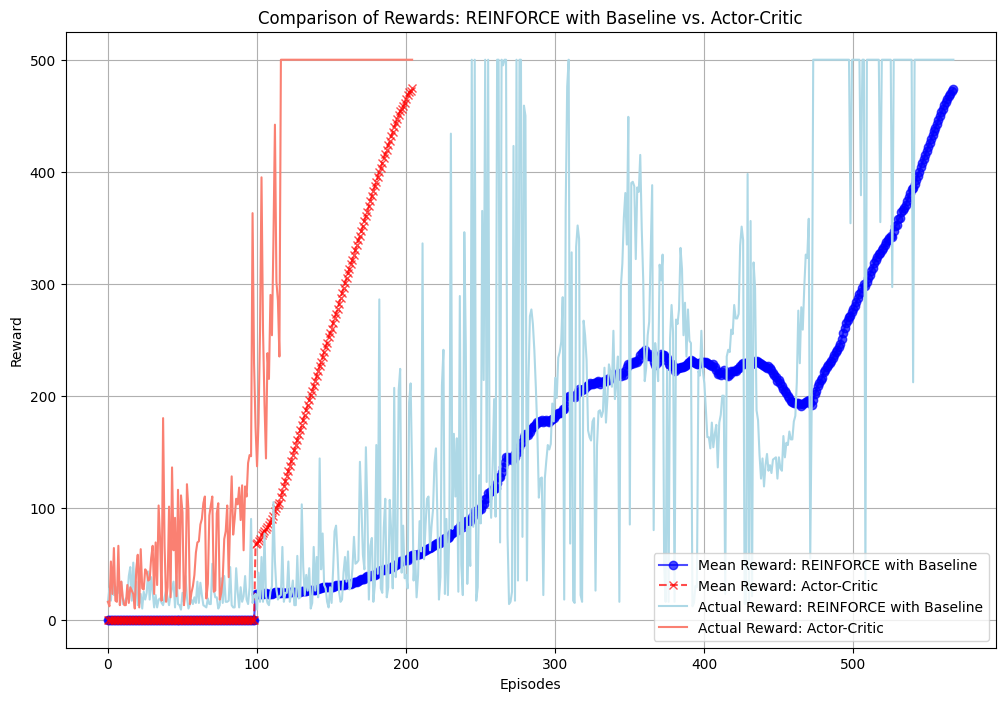

In [21]:
import matplotlib.pyplot as plt

# Assuming 'mean_rewards', 'mean_rewards_a_c', 'reward', and 'reward_a_c' are defined.

plt.figure(figsize=(12, 8))  # Adjust figure size for better visibility and to accommodate additional information.

# Plot mean rewards with solid lines
plt.plot(mean_rewards, label='Mean Reward: REINFORCE with Baseline', linestyle='-', marker='o', color='blue', alpha=0.7)
plt.plot(mean_rewards_a_c, label='Mean Reward: Actor-Critic', linestyle='--', marker='x', color='red', alpha=0.7)
plt.plot(b, label='Mean Reward: REINFORCE', linestyle='--', marker='x', color='red', alpha=0.7)


# Plot actual rewards as lines with a different style or transparency
plt.plot(rewards, label='Actual Reward: REINFORCE with Baseline', color='lightblue', alpha=1)
plt.plot(rewards_a_c, label='Actual Reward: Actor-Critic', color='salmon', alpha=1)
plt.plot(a, label='Actual Reward: Actor-Critic', color='salmon', alpha=1)

plt.title('Comparison of Rewards: REINFORCE with Baseline vs. Actor-Critic')  # Add a title
plt.xlabel('Episodes')  # X-axis label
plt.ylabel('Reward')  # Y-axis label
plt.legend()  # Show legend to identify lines and points
plt.grid(True)  # Add grid for better readability

plt.savefig('comparison_rewards_detailed.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


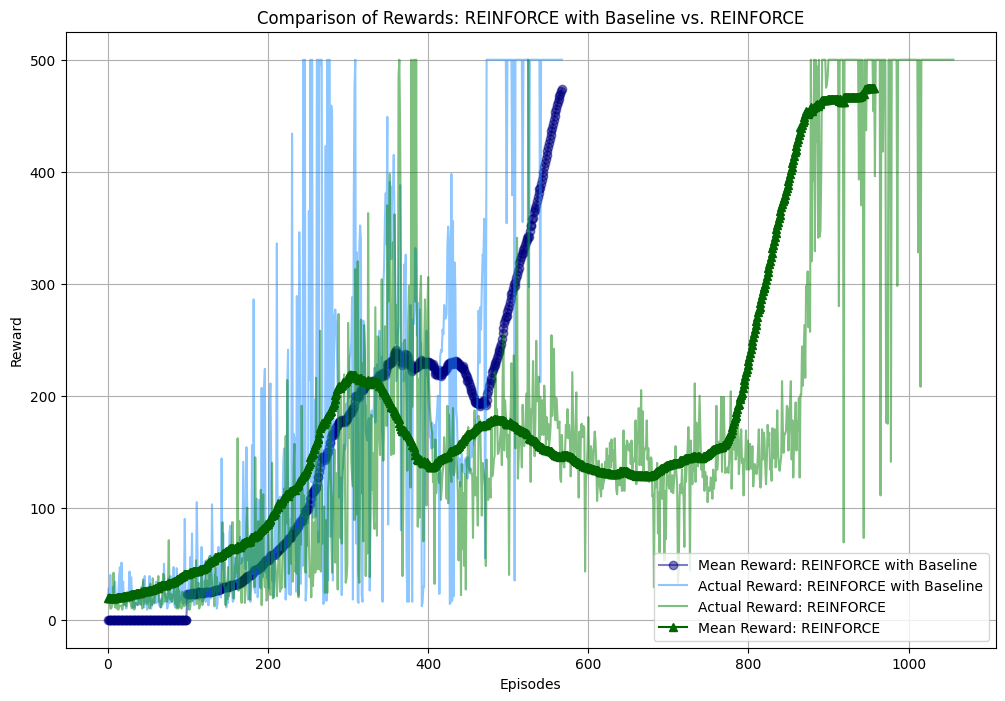

In [31]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))  # Adjust figure size for better visibility and to accommodate additional information.

# Plot mean rewards with solid lines for REINFORCE with baseline and Actor-Critic
plt.plot(mean_rewards, label='Mean Reward: REINFORCE with Baseline', linestyle='-', marker='o', color='navy', alpha=0.5)
# plt.plot(mean_rewards_a_c, label='Mean Reward: Actor-Critic', linestyle='--', marker='x', color='darkred', alpha=1)

# Plot actual rewards as lines with stronger colors for REINFORCE with baseline and Actor-Critic
plt.plot(rewards, label='Actual Reward: REINFORCE with Baseline', color='dodgerblue', alpha=0.5)
# plt.plot(rewards_a_c, label='Actual Reward: Actor-Critic', color='crimson', alpha=1)

# Add REINFORCE only data: 'a' for actual rewards and 'b' for mean rewards
plt.plot(a, label='Actual Reward: REINFORCE', color='green', alpha=0.5)
plt.plot(b, label='Mean Reward: REINFORCE', marker='^', color='darkgreen', alpha=1)

# plt.title('Comparison of Rewards: REINFORCE with Baseline vs. Actor-Critic vs. REINFORCE')  # Add a title
plt.title('Comparison of Rewards: REINFORCE with Baseline vs. REINFORCE')  # Add a title

plt.xlabel('Episodes')  # X-axis label
plt.ylabel('Reward')  # Y-axis label
plt.legend()  # Show legend to identify lines
plt.grid(True)  # Add grid for better readability

plt.savefig('comparison_rewards_all_series.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


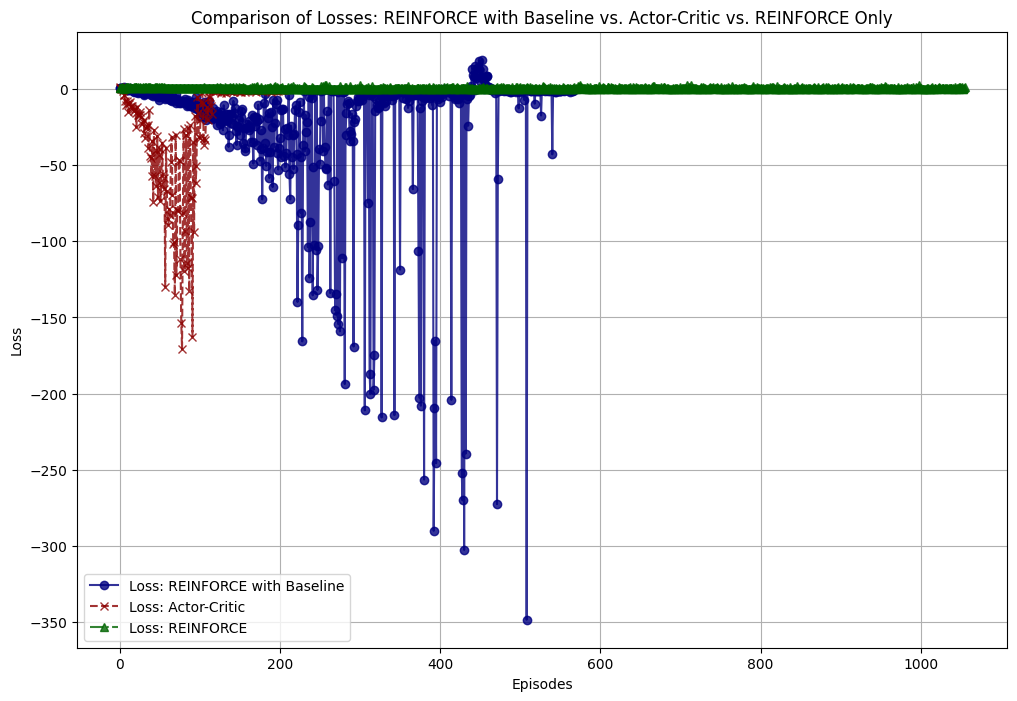

In [35]:
import matplotlib.pyplot as plt

# Assuming 'z', 'x', and 'c' are defined as the losses for REINFORCE with baseline, Actor-Critic, and just REINFORCE, respectively.

plt.figure(figsize=(12, 8))  # Adjust figure size for better visibility and to accommodate additional information.

# Plot losses for each algorithm with distinct styles
plt.plot(losses, label='Loss: REINFORCE with Baseline', linestyle='-', marker='o', color='navy', alpha=0.8)
plt.plot(losses_a_c, label='Loss: Actor-Critic', linestyle='--', marker='x', color='darkred', alpha=0.8)
plt.plot(c, label='Loss: REINFORCE', linestyle='-.', marker='^', color='darkgreen', alpha=0.8)

plt.title('Comparison of Losses: REINFORCE with Baseline vs. Actor-Critic vs. REINFORCE Only')  # Add a title
plt.xlabel('Episodes')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Show legend to identify lines
plt.grid(True)  # Add grid for better readability

plt.savefig('comparison_losses_all_algorithms.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


In [11]:
mean_rewards_a_c

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 67.3,
 68.51,
 70.15,
 72.2,
 75.92,
 77.87,
 79.63,
 80.91,
 82.63,
 84.65,
 87.21,
 89.56,
 92.82,
 97.11,
 99.82,
 102.52,
 104.58,
 109.32,
 114.09,
 118.99,
 123.54,
 127.96,
 132.85,
 137.22,
 141.94,
 146.67,
 151.22,
 155.79,
 160.44,
 165.08,
 169.53,
 173.87,
 178.64,
 182.95,
 187.64,
 191.62,
 195.91,
 200.74,
 203.94,
 208.28,
 213.12,
 217.83,
 221.82,
 226.62,
 230.26,
 234.64,
 238.73,
